In [14]:
import numpy as np
import pickle
import torch
import sys
import matplotlib.pyplot as plt
from matplotlib import cm,colors
from warnings import filterwarnings
from tqdm import tqdm

filterwarnings('ignore')
sys.path.append('../src')

import scanpy as sc
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=False)

from scipy.stats import pearsonr
from sklearn.metrics import r2_score

# 1. Visualization

## 1.1 Read model

In [2]:
# read the model with the sparse graph (selected based on "Model Selection" below)
savedir = '../result/run1678517572' 

with open(f'{savedir}/ptb_targets.pkl', 'rb') as f:
	ptb_targets = pickle.load(f)

model = torch.load(f'{savedir}/best_model.pt')

## 1.2 DAGs

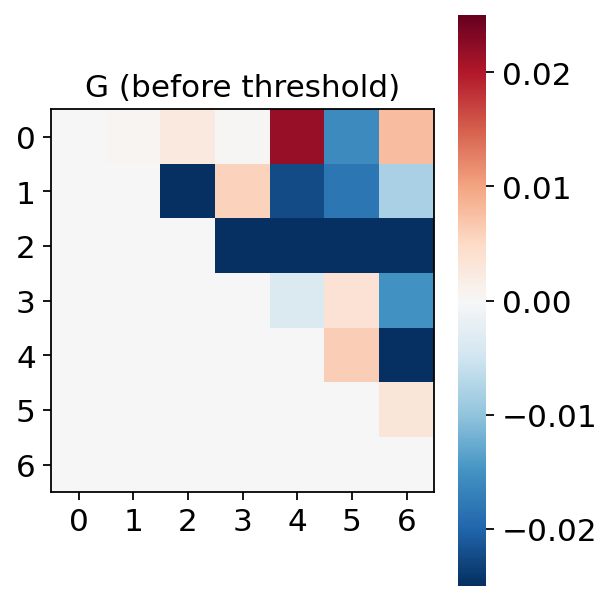

In [3]:
G_dense = torch.triu(model.G, diagonal=1).cpu().detach().numpy()

im = plt.imshow(G_dense, cmap=plt.cm.RdBu_r, vmin=-0.025, vmax=0.025)
plt.grid(False)
plt.xticks(range(7), range(7))
plt.yticks(range(7), range(7))
cb = plt.colorbar(im)
cb.outline.set_visible(False)
plt.title('G (before threshold)');
plt.tight_layout()
# plt.savefig('./figures/DAG-dense.pdf')

number of edges (after threshold): 15
number of possible edges: 21


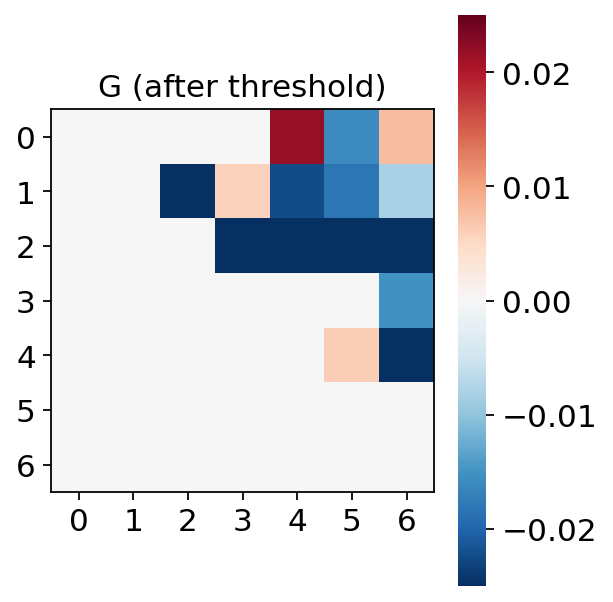

In [4]:
G = np.multiply(G_dense, abs(G_dense)>0.005)

im = plt.imshow(G, cmap=plt.cm.RdBu_r, vmin=-0.025, vmax=0.025)
plt.grid(False)
plt.xticks(range(7), range(7))
plt.yticks(range(7), range(7))
cb = plt.colorbar(im)
cb.outline.set_visible(False)
plt.title('G (after threshold)')
plt.tight_layout()
# plt.savefig('./figures/DAG-sparse.pdf')

print('number of edges (after threshold):', (abs(G_dense)>0.005).sum())
print('number of possible edges:', int(model.z_dim*(model.z_dim-1)/2))

there are no undirected edges
plotting...


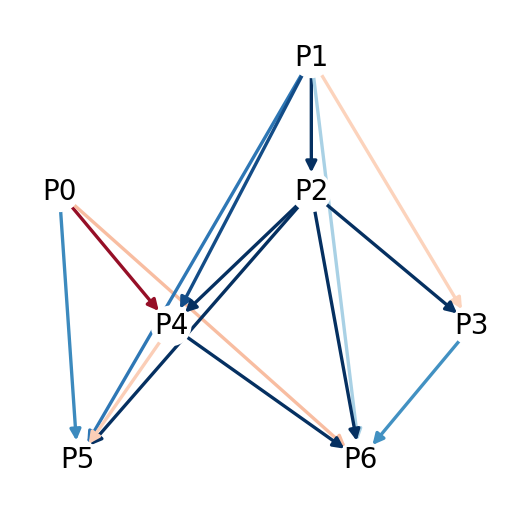

In [5]:
import graphical_models as gm

dag = gm.DAG(set(range(7)))

for i in range(7):
    for j in np.arange(i, 7, 1):
        if abs(G[i,j])>0.005:
            dag.add_arc(i,j)

node_label = [f'P{i}' for i in range(7)]

sys.path.append('..')          
import visualize
from importlib import reload
reload(visualize)

visualize.draw(dag, edge_weights=G, savefile=None, node_label=node_label) #savefile='./figures/DAG.pdf

In [6]:
gene_c_mxidx = []
gene_c_vec = []

for i in tqdm(range(105)):
	c = torch.zeros((1,105), dtype=torch.double)
	c[0][i] = 1
	c = c.to(model.device)
	gene_c_mxidx.append(model.c_encode(c, temp=20)[0].argmax().item())
	gene_c_vec.append(model.c_encode(c, temp=20)[0].detach()[0])

100%|██████████| 105/105 [00:00<00:00, 175.18it/s]


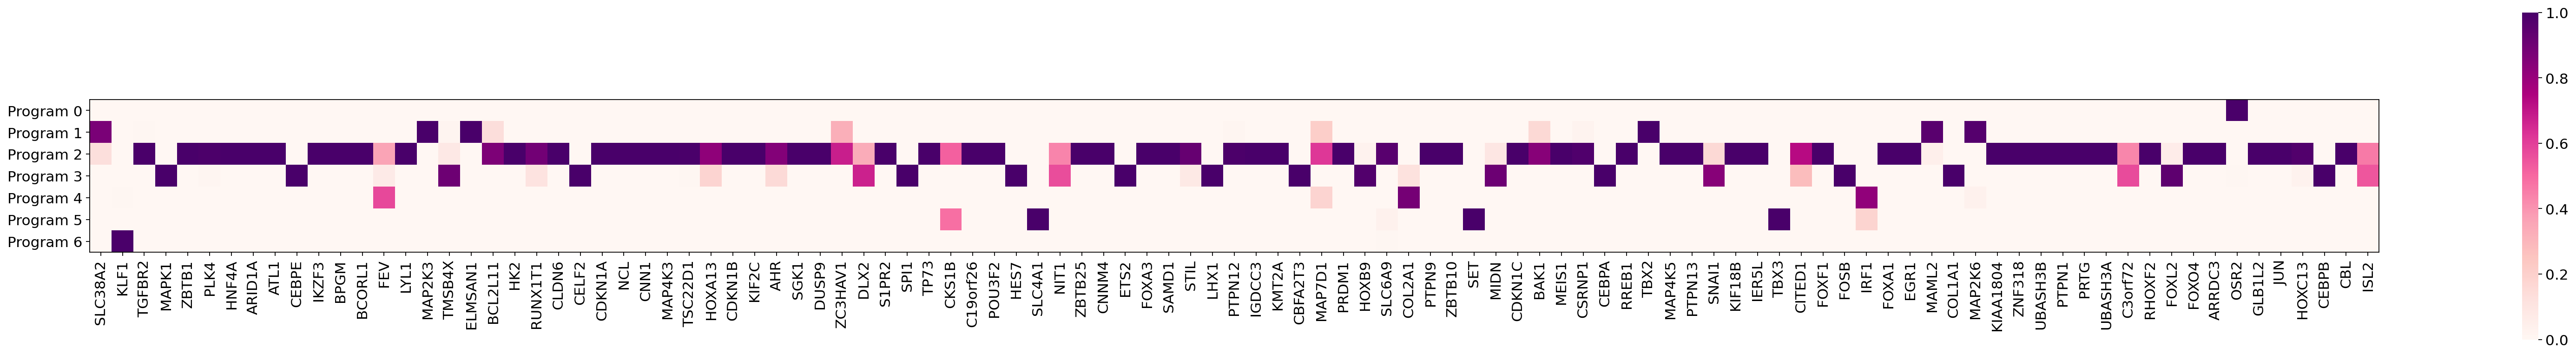

In [7]:
gene_c_mat = np.array([g_vec.cpu().numpy() for g_vec in gene_c_vec])

plt.figure(figsize=(40,5))
im = plt.imshow(gene_c_mat.T[:,:], cmap=plt.cm.RdPu, vmin=0, vmax=1)
plt.grid(False)

cb = plt.colorbar(im)
cb.outline.set_visible(False)
plt.yticks(range(7), [f'Program {i}' for i in range(7)]);
plt.xticks(range(105), np.array(ptb_targets)[:], rotation=90);
plt.tight_layout()
# plt.savefig('./figures/programs.pdf')

## 1.3 DAG gene

In [8]:
print('Genes in different programs (nodes):')
for i in set(gene_c_mxidx):
    list_tmp = [ptb_targets[j] for j in range(105) if gene_c_mxidx[j]==i]
    print(i, list_tmp)

Genes in different programs (nodes):
0 ['OSR2']
1 ['SLC38A2', 'MAP2K3', 'ELMSAN1', 'TBX2', 'MAML2', 'MAP2K6']
2 ['TGFBR2', 'ZBTB1', 'PLK4', 'HNF4A', 'ARID1A', 'ATL1', 'IKZF3', 'BPGM', 'BCORL1', 'LYL1', 'BCL2L11', 'HK2', 'RUNX1T1', 'CLDN6', 'CDKN1A', 'NCL', 'CNN1', 'MAP4K3', 'TSC22D1', 'HOXA13', 'CDKN1B', 'KIF2C', 'AHR', 'SGK1', 'DUSP9', 'ZC3HAV1', 'S1PR2', 'TP73', 'CKS1B', 'C19orf26', 'POU3F2', 'ZBTB25', 'CNNM4', 'FOXA3', 'SAMD1', 'STIL', 'PTPN12', 'IGDCC3', 'KMT2A', 'MAP7D1', 'PRDM1', 'SLC6A9', 'PTPN9', 'ZBTB10', 'CDKN1C', 'BAK1', 'MEIS1', 'CSRNP1', 'RREB1', 'MAP4K5', 'PTPN13', 'KIF18B', 'IER5L', 'CITED1', 'FOXF1', 'FOXA1', 'EGR1', 'KIAA1804', 'ZNF318', 'UBASH3B', 'PTPN1', 'PRTG', 'UBASH3A', 'RHOXF2', 'FOXO4', 'ARRDC3', 'GLB1L2', 'JUN', 'HOXC13', 'CBL']
3 ['MAPK1', 'CEBPE', 'TMSB4X', 'CELF2', 'DLX2', 'SPI1', 'HES7', 'NIT1', 'ETS2', 'LHX1', 'CBFA2T3', 'HOXB9', 'MIDN', 'CEBPA', 'SNAI1', 'FOSB', 'COL1A1', 'C3orf72', 'FOXL2', 'CEBPB', 'ISL2']
4 ['FEV', 'COL2A1', 'IRF1']
5 ['SLC4A1', 'SET'

In [9]:
print('Dominating genes in each program (node):')
for i in range(7):
    dict_tmp = {ptb_targets[j]: gene_c_vec[j][i].item() for j in range(105)}
    l = sorted(dict_tmp.items(), key=lambda x:x[1], reverse=True)
    n = max(1, np.where(np.array(list(dict_tmp.values()))>0.7)[0].__len__())
    print(i, {l[j][0]:l[j][1] for j in range(n)})

Dominating genes in each program (node):
0 {'OSR2': 0.9956925355915909}
1 {'TBX2': 0.9999993119084233, 'ELMSAN1': 0.9999617602551507, 'MAP2K3': 0.9999408942158747, 'MAP2K6': 0.9683941347390927, 'MAML2': 0.9569848864737057, 'SLC38A2': 0.8742591254538437}
2 {'DUSP9': 0.9999999999596667, 'ATL1': 0.9999999997992441, 'S1PR2': 0.9999999994788842, 'PRTG': 0.9999999992150643, 'IGDCC3': 0.9999999992130968, 'CLDN6': 0.9999999990783461, 'RREB1': 0.9999999946987344, 'MAP4K5': 0.9999999748921176, 'C19orf26': 0.9999999655688624, 'PRDM1': 0.9999998294174928, 'MAP4K3': 0.9999997917356184, 'LYL1': 0.9999990490522491, 'FOXA1': 0.9999987224109315, 'CBL': 0.9999983422046499, 'CNNM4': 0.9999978325909181, 'SGK1': 0.9999961595026011, 'BCORL1': 0.9999917334654657, 'IKZF3': 0.9999912181495142, 'PTPN9': 0.9999882477434842, 'SAMD1': 0.9999868432196412, 'CNN1': 0.9999861257395253, 'IER5L': 0.9999854793922627, 'RHOXF2': 0.9999837828088148, 'HK2': 0.9999801522338726, 'ZBTB1': 0.9999787812415414, 'ZNF318': 0.9999756

In [10]:
# plot nice DAG with graphviz
import graphviz

g = graphviz.Digraph('./figures/DAG2')
g.attr(ratio='0.6')

node_2_gene = {
    0: 'OSR2',
    1: 'TBX2',
    2: 'DUSP9',
    3: 'MAPK1\n / ETS2',
    4: 'COL2A1',
    5: 'SET',
    6: 'KLF1'
}

for node in dag.nodes:
# 	color = color_dict[node] if node in color_dict.keys() else 'white'
# 	b_color = b_color_dict[node] if node in b_color_dict.keys() else 'black'
	g.node(node_2_gene[node], style='filled,setlinewidth(0)', fillcolor='white', color='white', width='2', height='1', fontsize='36', fontname='Bold-Times-Roman')

for (i,j) in dag.arcs:
	g.edge(node_2_gene[i], node_2_gene[j], style='setlinewidth(4)', color='lightsteelblue', arrowsize='1')

In [11]:
g = graphviz.Digraph('./figures/DAG-programs')
g.attr(ratio='0.6')

node_2_gene = {
    i:f'Program {i}'
    for i in set(gene_c_mxidx)
}

for node in dag.nodes:
# 	color = color_dict[node] if node in color_dict.keys() else 'white'
# 	b_color = b_color_dict[node] if node in b_color_dict.keys() else 'black'
	g.node(node_2_gene[node], style='filled,setlinewidth(0)', fillcolor='white', color='white', width='2', height='1', fontsize='36', fontname='Bold-Times-Roman')

for (i,j) in dag.arcs:
	g.edge(node_2_gene[i], node_2_gene[j], style='setlinewidth(4)', color='slategrey', arrowsize='1')

## 1.4 UMAPs

In [12]:
# read data and compute umap
adata = sc.read_h5ad('../data/datasets/Norman2019_raw.h5ad')

sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=50)
sc.tl.umap(adata, min_dist=0.3) 

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:23)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:42)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:56)


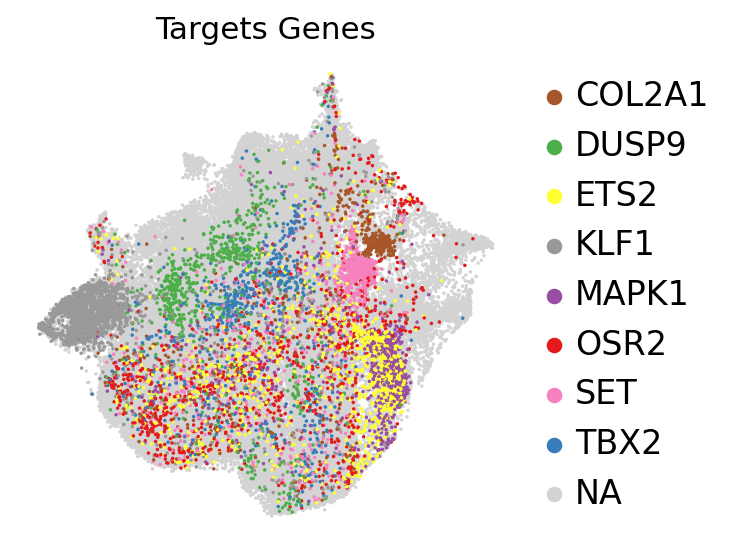

In [15]:
# visualize for dominating genes
vis_genes = ['OSR2', 
            'TBX2',
            'DUSP9',
            'MAPK1', 'ETS2',
            'COL2A1',
            'SET',
            'KLF1'
           ]
adata.obs['vis_ids'] = [i if i in vis_genes else '' for i in adata.obs['guide_ids']]

rgba_color = cm.Set1(np.linspace(0,1,len(vis_genes)))
sc.pl.umap(
    adata, 
    size=10, 
    color=['vis_ids'], 
    groups=vis_genes,
    palette={**{vis_genes[i]:rgba_color[i] for i in range(len(vis_genes))},**{'':'grey'}},
    title='Targets Genes',legend_fontsize=15,
    # save='_DAGgene.pdf'
);

# 2. (Pre-step) Model Selection

In [51]:
# recover latdim:
## latdim=7
# run1676269651 (20)
# run1676091376 (16)
# run1676090098 (16)
# run1678517513 (17)
# run1678517572 (15)
# run1678732499 (17)
# run1678732469 (16)

# not recover:
# run1676094660
# run1676094505
# run1676094440
# run1676090172
# run1675985058
# run1675985003
# run1675984929
# run1675984750
# run1675895646
# run1675895646
# run1678517615
# run1678516894
# run1678604439
# run1678604419
# run1678604398
# run1678604367

In [10]:
savedir = '../result/run1678517572'

with open(f'{savedir}/ptb_targets.pkl', 'rb') as f:
	ptb_targets = pickle.load(f)

    
model = torch.load(f'{savedir}/last_model.pt')
# model = torch.load(f'{savedir}/best_model.pt')

In [11]:
num_2_index = []
c_encode_vector = []

for i in tqdm(range(105)):
	c = torch.zeros((1,105), dtype=torch.double)
	c[0][i] = 1
	c = c.to(model.device)
	num_2_index.append(model.c_encode(c, temp=20)[0].argmax().item())
	c_encode_vector.append(model.c_encode(c, temp=20)[0].detach()[0])

100%|██████████| 105/105 [00:00<00:00, 238.25it/s]


In [12]:
num_2_index_candidate = []

for i in tqdm(range(105)):
	num_2_index_candidate.append(np.where((c_encode_vector[i]>1e-3).cpu().numpy()==True)[0])

100%|██████████| 105/105 [00:00<00:00, 31588.15it/s]


In [13]:
print(torch.triu(model.G, diagonal=1))
(abs(torch.triu(model.G, diagonal=1))>0.005).sum().item()

tensor([[ 0.0000,  0.0006,  0.0024,  0.0003,  0.0217, -0.0159,  0.0078],
        [ 0.0000,  0.0000, -0.2297,  0.0058, -0.0224, -0.0181, -0.0082],
        [ 0.0000,  0.0000,  0.0000, -0.0723, -0.0299, -0.0830, -0.1382],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -0.0036,  0.0036, -0.0151],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0061, -0.0455],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0031],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],
       device='cuda:1', dtype=torch.float64, grad_fn=<TriuBackward0>)


15

In [14]:
print(set(num_2_index))
print(len(set(num_2_index)))
print(model.z_dim)

{0, 1, 2, 3, 4, 5, 6}
7
7
